In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import nengo
from nengo.utils.ensemble import sorted_neurons

import sys
sys.path.append('../model')

from granule_golgi_circuit import GranuleGolgiCircuit

In [2]:
#from cycler import cycler
#default_cycler = (cycler(color=['#204a87', '#f57900', '#4e9a06', '#cc0000', '#75507b', '#8f5902']))
#plt.rc('axes', prop_cycle=default_cycler)

In [3]:
from scipy.special import legendre
def get_weights_for_delays(q, r):
    # compute the weights needed to extract the value at time r
    # from the network (r=0 is right now, r=1 is theta seconds ago)
    r = np.asarray(r)
    m = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    return m.reshape(q,-1).T

In [57]:
def rasterplot(ax, ts, A):
    N, n = A.shape
    color = '#c0c0c0'
    for i in range(n):
        for t in ts[np.where(A[:, i] != 0)]:
            ax.plot([t, t], [i + 0.5, i + 1.5], color=color, zorder=-100)
    ax.set_ylim(0.5, n + 0.5)
    if n < 5:
        ax.set_yticks(list(range(1, n + 1)))
    else:
        ax.set_yticks(list(range(1, n + 1, int(np.ceil(n / 5)))))

In [48]:
def run_experiment(mode, period=1.0, dt=1e-3):
    np.random.seed(45356)
    with nengo.Network() as model:
        # Stimulus
        nd_stim = nengo.Node(lambda t: 1 if 0.1<t%period<0.2 else 0)

        # Pre-ensemble
        ens_pcn = nengo.Ensemble(
            n_neurons=100,
            dimensions=1,
            neuron_type=nengo.Direct() if mode == "direct" else nengo.LIF()
        )
        nengo.Connection(nd_stim, ens_pcn)

        # Create the circuit
        net_golgi_granule = GranuleGolgiCircuit(
            ens_pcn,
            mode=mode)

        # Record the stimulus
        p_stim = nengo.Probe(nd_stim, synapse=None)

        # Record the spikes of the granule ensemble
        if mode == "direct":
            p_granule = nengo.Probe(
                net_golgi_granule.nd_delay_network)
        else:
            p_granule = nengo.Probe(
                net_golgi_granule.ens_granule,
                synapse=0.1)
        p_granule_spikes = nengo.Probe(
            net_golgi_granule.ens_granule.neurons,
            synapse=None)

    with nengo.Simulator(model, progress_bar=None, dt=dt) as sim:
        sim.run(period*2)

    indices = sorted_neurons(net_golgi_granule.ens_granule, sim, iterations=250)

    ts = sim.trange()
    return (
        ts[ts >= period] - period,
        sim.data[p_stim][ts >= period],
        sim.data[p_granule][ts >= period],
        sim.data[p_granule_spikes][:, indices][ts >= period])

In [49]:
# Run the experiments
ts, stim, V1_granule, _ = run_experiment('direct')
_ , _   , V2_granule, V2_granule_spikes = run_experiment('single_population')
_ , _   , V3_granule, V3_granule_spikes = run_experiment('two_populations_dales_principle')

Solved 200/200 neuron weights

In [50]:
# Delay the stimulus
dt = (ts[-1] - ts[0]) / (len(ts) - 1)
stim_delay = np.concatenate((np.zeros_like(np.arange(0, 0.2, dt)), stim[:, 0]))[:len(ts)]

V1_delayed = V1_granule @ get_weights_for_delays(6, 0.5)[0]
V2_delayed = V2_granule @ get_weights_for_delays(6, 0.4)[0] # account for 100ms filter
V3_delayed = V3_granule @ get_weights_for_delays(6, 0.4)[0] # account for 100ms filter

'NimbusRoman-Italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


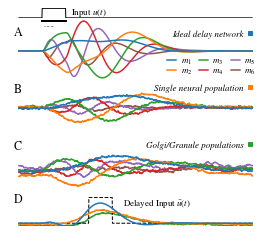

In [83]:
def hide_spines(ax):
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(False)
    return ax

fig = plt.figure(figsize=(4.6, 4.0))

ax1 = hide_spines(plt.subplot2grid((12, 1), (0, 0)))
ax1.plot(ts, stim, 'k', linewidth=1)
ax1.plot([0.1, 0.2], [-0.3, -0.3], clip_on=False, linewidth=2.0, color='k')
ax1.set_ylim(0, 1)
ax1.set_yticks([])
ax1.text(0.15, -0.6, '$100\\,\\mathrm{ms}$', 
         ha='center', va='top', fontsize=8,)
ax1.text(0.25, 1.2, 'Input $u(t)$', 
         ha='left', va='top', fontsize=9, transform=ax1.transAxes,)
ax1.set_xticks([])

ax2 = hide_spines(plt.subplot2grid((12, 1), (1, 0), sharex=ax1, rowspan=3))
for i in range(6):
    ax2.plot(ts, V1_granule[:, i], clip_on=False, label='$m_{}$'.format(i + 1), zorder=100-i)
ax2.text(0.92, 0.95, 'Ideal delay network', 
         ha='right', va='top', fontsize=9, transform=ax2.transAxes,
         fontdict={'style': 'italic'})
ax2.text(0.025, 0.825, 'A', fontsize=12,
         transform=ax2.transAxes,)
ax2.plot([0.945], [0.885], 's', markersize=4.0,
         transform=ax2.transAxes, color=cm.get_cmap('tab10')(0.0))
ax2.set_ylim(-0.6, 0.6)
ax2.set_yticks([])
ax2.legend(
    loc='lower right',
    ncol=3,
    bbox_to_anchor=(1, -0.2),
    labelspacing=0.0,
    handlelength=1.0,
    handletextpad=0.5,
    columnspacing=0.75)

ax3 = hide_spines(plt.subplot2grid((12, 1), (4, 0), sharex=ax1, rowspan=3))
twax = hide_spines(ax3.twinx())
twax.set_zorder(-2)
rasterplot(twax, ts, V2_granule_spikes[:, ::10])
twax.set_yticks([])
twax.set_ylim(-5, 30)

for i in range(6):
    ax3.plot(ts, V2_granule[:, i], clip_on=False, label='$m_{}$'.format(i + 1), zorder=100-i)
ax3.text(0.92, 1.0, 'Single neural population', 
         ha='right', va='top', fontsize=9, transform=ax3.transAxes,
         fontdict={'style': 'italic'})
ax3.plot([0.945], [0.935], 's', markersize=4.0,
         transform=ax3.transAxes, color=cm.get_cmap('tab10')(0.1))
ax3.text(0.025, 0.825, 'B', fontsize=12,
         transform=ax3.transAxes)
ax3.set_ylim(-0.6, 0.6)
ax3.set_yticks([])

ax4 = hide_spines(plt.subplot2grid((12, 1), (7, 0), sharex=ax1, rowspan=3))
twax = hide_spines(ax4.twinx())
twax.set_zorder(-2)
rasterplot(twax, ts, V3_granule_spikes[:, ::10])
twax.set_yticks([])
twax.set_ylim(-5, 30)

for i in range(6):
    ax4.plot(ts, V3_granule[:, i], clip_on=False, label='$m_{}$'.format(i + 1), zorder=100-i)
ax4.text(0.92, 1.0, 'Golgi/Granule populations', 
         ha='right', va='top', fontsize=9, transform=ax4.transAxes,
         fontdict={'style': 'italic'})
ax4.plot([0.945], [0.935], 's', markersize=4.0,
         transform=ax4.transAxes, color=cm.get_cmap('tab10')(0.2))
ax4.text(0.025, 0.825, 'C', fontsize=12,
         transform=ax4.transAxes)
ax4.set_ylim(-0.6, 0.6)
ax4.set_yticks([])

ax5 = hide_spines(plt.subplot2grid((12, 1), (10, 0), sharex=ax1, rowspan=2))
ax5.plot(ts, stim_delay, 'k--', linewidth=1)
ax5.plot(ts, V1_delayed, zorder=3)
ax5.plot(ts, V2_delayed, zorder=2)
ax5.plot(ts, V3_delayed, zorder=1)
ax5.text(0.45, 1.0, 'Delayed Input $\\tilde u(t)$', 
         ha='left', va='top', fontsize=9, transform=ax5.transAxes,)
ax5.text(0.025, 0.825, 'D', fontsize=12,
         transform=ax5.transAxes)
ax5.set_yticks([])
ax5.set_ylim(-0.1, 1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.0)

fig.savefig('delay_network_response.pdf', bbox_inches='tight', transparent=True)